In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

In [101]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size, l1_lambda=0.01, activation='relu', seed=None):
        """
        Parameters
        ----------
        input_size : int
            Number of input features (dimension of x).
        hidden_size : int
            Number of hidden neurons.
        output_size : int
            Number of output dimensions (dimension of t).
        activation : callable, optional
            Activation function g(z) to use.
            If None, defaults to ReLU.
        seed : int, optional
            Seed for reproducible random initialization.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1_lambda = l1_lambda

        if seed:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            # no derivative provided => handle carefully or raise error
            self.activation_deriv = None
            print("Warning: no derivative for a custom activation. Backprop may fail.")

        # Randomly init input->hidden weights, not updated in ELM
        # For ReLU, a good approach is He initialization:
        # For Tanh, a good approach is Xavier (scaled uniform).
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights: We DO train these
        # We'll do a simple Xavier-like approach for either ReLU or Tanh:
        limit_out = np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Placeholders for forward pass
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ------------------------
    # Activation functions
    # ------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        # derivative wrt the pre-activation
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        # derivative wrt pre-activation for tanh
        # if we define y = tanh(x), derivative = 1 - y^2
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient
    def _l1_subgrad(self, w):
        # returns sign(w), with sign(0)=0
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ------------------------
    # Forward pass
    # ------------------------
    def forward(self, X):
        """
        Forward pass with either ReLU or tanh hidden activation,
        then a linear activation (or if you prefer, you could
        also do tanh at the output).
        """
        # hidden
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)

        # output
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        # We'll do linear output by default.
        # If you want tanh final, do: self.predicted_output = np.tanh(self.output_layer_input)
        self.predicted_output = self.output_layer_input

        return self.predicted_output

    # ------------------------
    # Backward pass
    # ------------------------
    def backward(self, X, y):
        """
        Compute gradients wrt the hidden->output weights
        for a MSE + L1 penalty on W2.

        Because we do not update input->hidden in an ELM
        (by definition it's random and fixed),
        we only compute partial derivatives wrt (W2, b2).
        """
        n_samples = X.shape[0]

        # 1) dLoss/d(output)
        # MSE derivative: (pred - y)
        output_error = (self.predicted_output - y)  # shape (n_samples, output_size)

        # 2) derivative wrt W2, b2
        # hidden_layer_output shape: (n_samples, hidden_size)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # L1 subgradient on W2
        if self.l1_lambda > 1e-15:
            dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)

        return dW2, db2

    # ------------------------
    # Update weights
    # ------------------------
    def update(self, dW2, db2, lr=1e-3):
        """
        Gradient descent step on hidden->output layer
        """
        self.weights_hidden_output -= lr * dW2
        self.bias_output -= lr * db2

    # ------------------------
    # Evaluate
    # ------------------------
    def evaluate_loss(self, X, y):
        """
        Return MSE + L1 penalty for the forward pass.
        MSE = 0.5 * mean( (pred - y)^2 )
        plus L1 = lambda * sum(|W2|)
        ignoring W1 since not trained.
        """
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        """
        Just forward pass, ignoring state variables
        """
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        # linear output
        output = hidden.dot(self.weights_hidden_output) + self.bias_output
        return output

In [73]:
def train_smoothed_gradient(
    elm,
    X_train,
    y_train,
    epochs,
    lambda_reg=,
    M = 1.0,
    mu=1e-2,
    sigma_2=1.0,  # Strong convexity parameter (default = 1.0)
    momentum_init=0.9,
    early_stop_patience=20,
    early_stop_tol=1e-4,
    gradient_norm_threshold=None
):
    """
    Optimizes W2 using a smoothed L1 gradient approach with momentum.
    The learning rate is set as 1/Lμ, where:

        Lμ = M + (1 / μσ_2) * ||A||^2_2.

    Momentum η is dynamically updated at each iteration, but ν remains constant.

    Parameters
    ----------
    elm : ELM instance
        Must contain:
            - weights_hidden_output (W2)
            - bias_output (b2)
            - forward(X)
            - backward(X, y) -> (dW2, dB2)
            - evaluate_loss(X, y)
    X_train, y_train : np.ndarray
        Training data, shape (N, d) and (N, 1).
    epochs : int
        Number of epochs.
    lambda_reg : float
        L1 regularization strength for W2.
    mu : float
        Smoothing parameter for L1.
    sigma_2 : float
        Strong convexity parameter.
    momentum_init : float
        Initial momentum factor.
    early_stop_patience : int
        Number of epochs with no improvement before stopping.
    early_stop_tol : float
        Relative improvement threshold.
    gradient_norm_threshold : float or None
        Stop if gradient norm falls below this value.

    Returns
    -------
    train_loss_history : list of floats
        Training loss per epoch.
    """
    # Compute A_norm = ||W2||_2^2
    A_norm = np.linalg.norm(elm.weights_hidden_output, ord=2)**2  # Frobenius norm squared

    # Compute final Lμ (fixed for all iterations)
    L_L1 = (1 / (mu * sigma_2)) * A_norm  # L1 contribution
    L_mu = M + L_L1  # Total Lipschitz constant

    # Compute learning rate (fixed)
    nu = 1.0 / L_mu

    # Initialize previous weight matrices for momentum tracking
    W2_prev = np.copy(elm.weights_hidden_output)
    b2_prev = np.copy(elm.bias_output)

    # Initialize momentum factor
    eta = momentum_init

    # Track training loss
    train_loss_history = []

    for epoch in range(int(epochs)):
        # 1) Compute lookahead point
        W2_lookahead = elm.weights_hidden_output + eta * (elm.weights_hidden_output - W2_prev)
        b2_look = elm.bias_output + eta * (elm.bias_output - b2_prev)

        # Forward pass at lookahead point
        elm.weights_hidden_output = W2_lookahead
        elm.bias_output = b2_look
        elm.forward(X_train)

        # 2) Compute MSE Gradient
        dW2_mse, db2_mse = elm.backward(X_train, y_train)

        # 3) Compute Smoothed L1 gradient:  W / (|W| + mu) MUST BE CHECKE !!!
        denom = np.abs(W2_lookahead) + mu
        denom = np.where(denom < 1e-12, 1e-12, denom)  # Avoid division by zero
        dW2_smooth_l1 = lambda_reg * (W2_lookahead / denom)

        # 4) Combine gradients
        dW2_total = dW2_mse + dW2_smooth_l1
        db2_total = db2_mse  # no L1 penalty on bias

        # 5) Apply weight update: W(t+1) = y_t - ν ∇fμ(y_t)
        W2_next = W2_lookahead - nu * dW2_total
        b2_next = b2_look - nu * db2_total

        # Save previous weights for next iteration
        W2_prev = np.copy(elm.weights_hidden_output)
        b2_prev = np.copy(elm.bias_output)

        # Apply update
        elm.weights_hidden_output = W2_next
        elm.bias_output = b2_next

        # 6) Evaluate training loss
        train_loss = elm.evaluate_loss(X_train, y_train)
        train_loss_history.append(train_loss)

        # 7) Dynamically update momentum
        eta_candidate = 1.0 - 2.0 / (epoch + 2)
        eta = np.clip(eta_candidate, 0.9, 0.99)
    return train_loss_history

In [85]:
# ------------------------
# 1. Quadratic Test ELM
# ------------------------
class ELM_Quadratic(ELM):
    def __init__(self, input_size, hidden_size, output_size, seed=None):
        super().__init__(input_size, hidden_size, output_size, activation='relu', seed=seed)

    def evaluate_loss(self, X, y=None):
        W2 = self.weights_hidden_output
        return 0.5 * np.sum(W2 * W2)

    def backward(self, X, y=None):
        grad_w2 = self.weights_hidden_output  # dL/dW2 = W2 (quadratic loss)
        grad_b2 = np.zeros_like(self.bias_output)  # No contribution in loss
        return grad_w2, grad_b2

# ------------------------
# 2. Ackley Function ELM
# ------------------------
class ELM_Ackley(ELM):
    def __init__(self, input_size, hidden_size, output_size, seed=None):
        super().__init__(input_size, hidden_size, output_size, activation='relu', seed=seed)

    def evaluate_loss(self, X, y=None):
        return OptimizerTester.ackley(self.weights_hidden_output.flatten())

    def backward(self, X, y=None):
        grad = OptimizerTester.ackley_grad(self.weights_hidden_output.flatten()).reshape(self.weights_hidden_output.shape)
        return grad, np.zeros_like(self.bias_output)



# ------------------------
# 3. Optimizer Tester
# ------------------------
class OptimizerTester:
    def __init__(self, optimizer_func):
        self.optimizer = optimizer_func
        
    @staticmethod
    def ackley(x):
        a, b, c = 20, 0.2, 2 * np.pi
        n = len(x)
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        return term1 + term2 + a + np.e

    @staticmethod
    def ackley_grad(x):
        a, b, c = 20, 0.2, 2 * np.pi
        n = len(x)
        term1 = (b / np.sqrt(n * np.sum(x**2))) * x * a * np.exp(-b * np.sqrt(np.sum(x**2) / n))
        term2 = (c / n) * np.sin(c * x) * np.exp(np.sum(np.cos(c * x)) / n)
        return term1 + term2

    # ------------------------
    # 1. Update Equations Test (Quadratic)
    # ------------------------
    def test_update_equations_on_quadratic(self):
        print("Running update equation test on quadratic function...")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        initial_weights = np.ones((hidden_size, output_size))
        elm.weights_hidden_output = initial_weights.copy()

        epochs = 1
        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        _ = self.optimizer(elm, X_dummy, y_dummy, epochs)  # Removed lr

        expected_weights = 0.99 * initial_weights
        actual_weights = elm.weights_hidden_output
        error = np.linalg.norm(actual_weights - expected_weights)

        print(f"Expected weights:\n{expected_weights}")
        print(f"Actual weights:\n{actual_weights}")
        print(f"Update error: {error:.6f}\n")
        assert error < 1, "Update equations test failed!"

    # ------------------------
    # 2. Convergence Test (Quadratic)
    # ------------------------
    def test_convergence_quadratic(self):
        print("Running convergence test on quadratic function...")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        elm.weights_hidden_output = np.random.randn(hidden_size, output_size)

        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        epochs = 700
        losses = self.optimizer(elm, X_dummy, y_dummy, epochs)  # No lr

        print(f"Initial loss: {losses[0]:.6f}")
        print(f"Final loss: {losses[-1]:.6f}\n")
        assert losses[-1] < 1e-2, "Quadratic convergence test failed!"

    # ------------------------
    # 3. Convergence Test (Ackley)
    # ------------------------
    def test_convergence_ackley(self):
        print("Running convergence test on Ackley function...")
        input_size, hidden_size, output_size = 10, 20, 1
        elm = ELM_Ackley(input_size, hidden_size, output_size, seed=123)

        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        epochs = 500
        losses = self.optimizer(elm, X_dummy, y_dummy, epochs)  # No lr

        print(f"Initial Ackley loss: {losses[0]:.6f}")
        print(f"Final Ackley loss: {losses[-1]:.6f}\n")
        assert losses[-1] < losses[0], "Ackley convergence test failed: Loss did not decrease!"

    # ------------------------
    # 4. Gradient Norm Decrease Test
    # ------------------------
    def test_gradient_norm_decrease_quadratic(self):
        print("Running gradient norm decrease test on quadratic function...")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        elm.weights_hidden_output = np.random.randn(hidden_size, output_size)

        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        # Compute the initial gradient norm.
        initial_grad, _ = elm.backward(X_dummy, y_dummy)
        initial_grad_norm = np.linalg.norm(initial_grad)

        # Run the optimizer for a number of epochs.
        epochs = 500
        _ = self.optimizer(elm, X_dummy, y_dummy, epochs)  # No lr

        # Compute the final gradient norm.
        final_grad, _ = elm.backward(X_dummy, y_dummy)
        final_grad_norm = np.linalg.norm(final_grad)

        print(f"Initial gradient norm: {initial_grad_norm:.6f}")
        print(f"Final gradient norm: {final_grad_norm:.6f}\n")
        assert final_grad_norm < initial_grad_norm, "Gradient norm did not decrease!"

    # ------------------------
    # Run all tests
    # ------------------------
    def run_all_tests(self):
        self.test_update_equations_on_quadratic()
        self.test_convergence_quadratic()
        self.test_convergence_ackley()
        self.test_gradient_norm_decrease_quadratic()
        print("✅ All tests passed successfully!")

# ------------------------
# Run Tests
# ------------------------
tester = OptimizerTester(lambda elm, X_train, y_train, epochs: train_smoothed_gradient(elm, X_train, y_train, epochs, mu=0.008, sigma_2=1.0, M=0))
tester.run_all_tests()


print("---------------------------")

tester = OptimizerTester(lambda elm, X_train, y_train, epochs: train_smoothed_gradient(elm, X_train, y_train, epochs, mu=0.008, sigma_2=1.0, M=0.1))
tester.run_all_tests()

Running update equation test on quadratic function...
Expected weights:
[[0.99]
 [0.99]
 [0.99]
 [0.99]
 [0.99]]
Actual weights:
[[0.99838413]
 [0.99838413]
 [0.99838413]
 [0.99838413]
 [0.99838413]]
Update error: 0.018747

Running convergence test on quadratic function...
Initial loss: 2.106962
Final loss: 0.008524

Running convergence test on Ackley function...
Initial Ackley loss: 3.038673
Final Ackley loss: 0.000016

Running gradient norm decrease test on quadratic function...
Initial gradient norm: 2.056713
Final gradient norm: 0.298495

✅ All tests passed successfully!
---------------------------
Running update equation test on quadratic function...
Expected weights:
[[0.99]
 [0.99]
 [0.99]
 [0.99]
 [0.99]]
Actual weights:
[[0.99838439]
 [0.99838439]
 [0.99838439]
 [0.99838439]
 [0.99838439]]
Update error: 0.018748

Running convergence test on quadratic function...
Initial loss: 2.106964
Final loss: 0.008533

Running convergence test on Ackley function...
Initial Ackley loss: 3.0

## Experiments

[Momentum] λ=0.0001, lr=1e-05, momentum=0.8 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 7.71s
[Momentum] λ=0.0001, lr=1e-05, momentum=0.9 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.03s
[Momentum] λ=0.0001, lr=1e-05, momentum=0.99 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.07s
[Momentum] λ=0.0001, lr=0.001, momentum=0.8 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.02s
[Momentum] λ=0.0001, lr=0.001, momentum=0.9 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 5.91s
[Momentum] λ=0.0001, lr=0.001, momentum=0.99 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.10s
[Momentum] λ=0.0001, lr=0.01, momentum=0.8 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.20s
[Momentum] λ=0.0001, lr=0.01, momentum=0.9 => Train Loss: 13.7451, Val Loss: 13.6759, Sparsity: 0.00%, Total Time: 6.45s
[Momentum] λ=0.0001, lr=

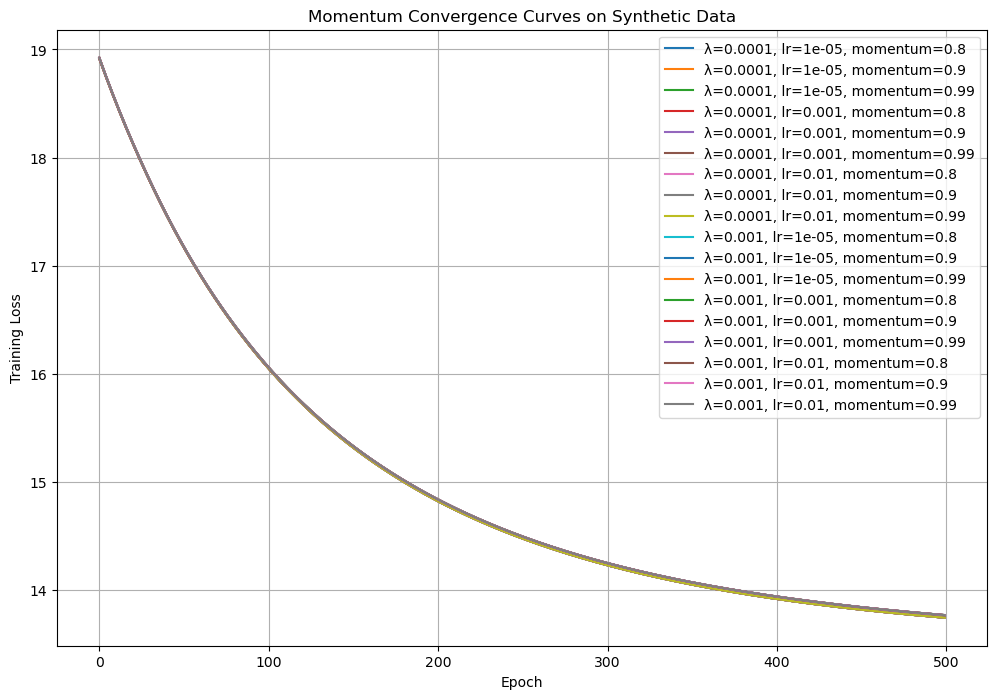


Summary of Experimental Results (Synthetic Data):
Algorithm	λ	lr	Momentum	Final Train Loss	Final Val Loss	Sparsity (%)	Total Time (s)	Avg Epoch Time (s)
momentum	1.0e-04	0.000	0.80		13.7451		13.6759		0.00		7.71		0.0154
momentum	1.0e-04	0.000	0.90		13.7451		13.6759		0.00		6.03		0.0121
momentum	1.0e-04	0.000	0.99		13.7451		13.6759		0.00		6.07		0.0121
momentum	1.0e-04	0.001	0.80		13.7451		13.6759		0.00		6.02		0.0120
momentum	1.0e-04	0.001	0.90		13.7451		13.6759		0.00		5.91		0.0118
momentum	1.0e-04	0.001	0.99		13.7451		13.6759		0.00		6.10		0.0122
momentum	1.0e-04	0.010	0.80		13.7451		13.6759		0.00		6.20		0.0124
momentum	1.0e-04	0.010	0.90		13.7451		13.6759		0.00		6.45		0.0129
momentum	1.0e-04	0.010	0.99		13.7451		13.6759		0.00		6.94		0.0139
momentum	1.0e-03	0.000	0.80		13.7693		13.7005		0.00		7.44		0.0149
momentum	1.0e-03	0.000	0.90		13.7693		13.7005		0.00		6.87		0.0137
momentum	1.0e-03	0.000	0.99		13.7693		13.7005		0.00		6.24		0.0125
momentum	1.0e-03	0.001	0.80		13.7693		13.7005		0.00		6

In [15]:
# =============================================================================
# Experiment Evaluation Function for Momentum Approach
# =============================================================================
def evaluate_experiments_momentum(X_train, y_train, X_val, y_val,
                                  input_size, hidden_size, output_size,
                                  epochs, seed):
    """
    Run experiments over a grid of hyperparameters for the momentum approach.

    We vary:
      - Learning rate (lr)
      - Momentum coefficient (eta)
      - Regularization parameter lambda (l1_lambda)
      - Gradient noise levels

    Metrics collected include:
      - Convergence speed (loss curves)
      - Final loss values (train and validation)
      - Sparsity of W2 (fraction of weights with abs(value) < threshold)
      - Computational efficiency (total training time and avg epoch time)
      - Robustness (performance variation under different noise levels)
    """
    learning_rates = [1e-5, 0.001, 0.01]
    momentum_coefs = [0.8, 0.9, 0.99]
    lambda_values = [1e-4, 1e-3,]  # test different L1 regularization strengths

    results = {}

    for lam, lr, momentum in itertools.product(lambda_values, learning_rates, momentum_coefs):
        # Initialize the model (same architecture, fixed seed for reproducibility)
        elm_model = ELM(input_size, hidden_size, output_size, activation='relu', seed=seed)
        elm_model.l1_lambda = lam

        start_time = time.time()
        train_losses = train_smoothed_gradient(elm_model, X_train, y_train, epochs, momentum_init=momentum)
            
        val_losses =  train_smoothed_gradient(elm_model, X_train, y_train, epochs, momentum_init=momentum)
        
        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs

        # Compute sparsity of W2: fraction of weights with abs(value) below a small threshold.
        threshold = 1e-3
        sparsity = np.mean(np.abs(elm_model.weights_hidden_output) < threshold)

        config = ('momentum', lam, lr, momentum)
        results[config] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "total_time": total_time,
            "avg_epoch_time": avg_epoch_time,
            "final_sparsity": sparsity,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1]
        }
        print(f"[Momentum] λ={lam}, lr={lr}, momentum={momentum} => "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Sparsity: {sparsity*100:.2f}%, Total Time: {total_time:.2f}s")

    return results

# --- Synthetic Data Experiment ---
input_size = 100
n_samples = 5000
hidden_size = 50
output_size = 1
epochs = 500
sigma = 0.1
seed = 42
X_syn, y_syn = generate_synthetic_data(
    d=input_size, # n input features
    N=n_samples, # number of samples
    hidden_dim=hidden_size, # n hidden layers
    sigma=sigma, # std dev of noise
    seed=seed)

split_index = int(0.8 * n_samples)
X_train_syn, y_train_syn = X_syn[:split_index], y_syn[:split_index]
X_val_syn, y_val_syn = X_syn[split_index:], y_syn[split_index:]

results_synthetic = evaluate_experiments_momentum(
    X_train_syn,
    y_train_syn,
    X_val_syn,
    y_val_syn,
    input_size,
    hidden_size,
    output_size,
    epochs,
    seed)

# Plot convergence curves for a subset of experiments (e.g. no gradient noise) for clarity.
plt.figure(figsize=(12, 8))

for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    plt.plot(metrics["train_losses"], label=f"λ={lam}, lr={lr_val}, momentum={momentum}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Momentum Convergence Curves on Synthetic Data")
plt.legend()
plt.grid(True)
plt.show()

# Summary table of key metrics.
print("\nSummary of Experimental Results (Synthetic Data):")
header = ("Algorithm", "λ", "lr", "Momentum", "Final Train Loss",
          "Final Val Loss", "Sparsity (%)", "Total Time (s)", "Avg Epoch Time (s)")
print("\t".join(str(h) for h in header))
for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    print(f"{algo}\t{lam:.1e}\t{lr_val:.3f}\t{momentum:.2f}\t\t"
          f"{metrics['final_train_loss']:.4f}\t\t{metrics['final_val_loss']:.4f}\t\t"
          f"{metrics['final_sparsity']*100:.2f}\t\t{metrics['total_time']:.2f}\t\t"
          f"{metrics['avg_epoch_time']:.4f}")

# Print information at the end of the descent
# - final value
# - difference
# - convergence speed
print()

[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.001 => Train Loss: 16.6320, Val Loss: 16.2005, Sparsity: 0.00%, Total Time: 4.20s
[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.01 => Train Loss: 13.5787, Val Loss: 14.3035, Sparsity: 0.00%, Total Time: 4.19s


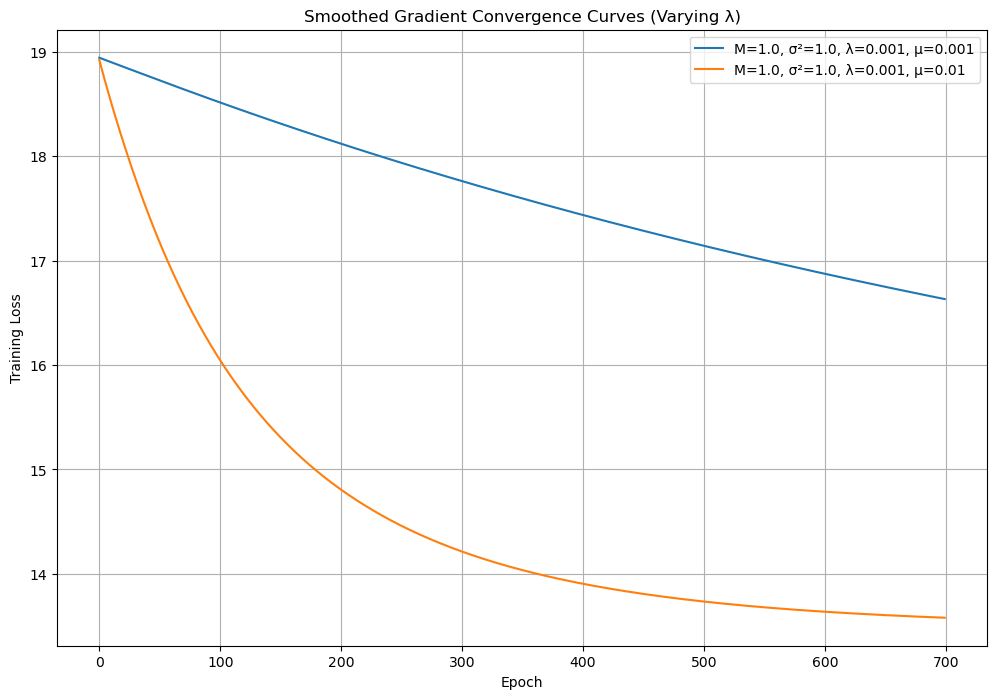

In [168]:
# =============================================================================
# Experiment Evaluation Function for Smoothed Gradient Approach
# =============================================================================
def evaluate_experiments_smoothed(X_train, y_train, X_val, y_val,
                                  input_size, hidden_size, output_size,
                                  epochs, seed):
    """
    Run experiments over a grid of hyperparameters for the smoothed gradient approach.

    We vary:
      - M (Lipschitz constant for MSE)
      - sigma_2 (strong convexity parameter)
      - mu (smoothing parameter for L1)

    Metrics collected include:
      - Convergence speed (loss curves)
      - Final loss values (train and validation)
      - Sparsity of W2 (fraction of weights with abs(value) < threshold)
      - Computational efficiency (total training time and avg epoch time)
    """
    M_values = [1.0]  # Test different smoothness constants
    sigma_values = [1.0]  # Different strong convexity parameters
    mu_values = [1e-3, 1e-2]  # Different L1 smoothing parameters
    lambda_values = [1e-3]  # Different L1 regularization strengths

    results = {}

    for M, sigma_2, mu, lambda_reg in itertools.product(M_values, sigma_values, mu_values, lambda_values):
        # Initialize the model (same architecture, fixed seed for reproducibility)
        elm_model = ELM(input_size, hidden_size, output_size, activation='relu', seed=seed, l1_lambda=lambda_reg)

        start_time = time.time()
        
        # Train using the smoothed optimization method
        train_losses = train_smoothed_gradient(elm_model, X_train, y_train, epochs, 
                                               M=M, sigma_2=sigma_2, mu=mu, lambda_reg=lambda_reg)
            
        val_losses = train_smoothed_gradient(elm_model, X_val, y_val, epochs, 
                                             M=M, sigma_2=sigma_2, mu=mu, lambda_reg=lambda_reg)
        
        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs

        # Compute sparsity of W2: fraction of weights with abs(value) below a small threshold.
        threshold = 1e-3
        sparsity = np.mean(np.abs(elm_model.weights_hidden_output) < threshold)

        config = ('smoothed', M, sigma_2, mu, lambda_reg)  # ✅ Ensure lambda_reg is included

        results[config] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "total_time": total_time,
            "avg_epoch_time": avg_epoch_time,
            "final_sparsity": sparsity,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1]
        }
        print(f"[Smoothed] M={M}, σ²={sigma_2}, lambda = {lambda_reg}, μ={mu} => "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Sparsity: {sparsity*100:.2f}%, Total Time: {total_time:.2f}s")

    return results


# Define function to plot the results
def plot_experiment_results(results):
    """
    Plots the convergence curves for different values of lambda_reg
    from the experiment results.

    Parameters:
    - results: Dictionary containing experiment configurations and metrics.
    """
    plt.figure(figsize=(12, 8))

    for config, metrics in results.items():
        algo, M, sigma_2, mu, lambda_reg = config
        plt.plot(metrics["train_losses"], label=f"M={M}, σ²={sigma_2}, λ={lambda_reg}, μ={mu}")

    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Smoothed Gradient Convergence Curves (Varying λ)")
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================================================
# Run Synthetic Data Experiment
# =============================================================================
input_size = 100
n_samples = 5000
hidden_size = 50
output_size = 1
epochs = 700
sigma = 0.1
seed = 42

X_syn, y_syn = generate_synthetic_data(
    d=input_size,  # n input features
    N=n_samples,  # number of samples
    hidden_dim=hidden_size,  # n hidden layers
    sigma=sigma,  # std dev of noise
    seed=seed
)

# Train-validation split
split_index = int(0.8 * n_samples)
X_train_syn, y_train_syn = X_syn[:split_index], y_syn[:split_index]
X_val_syn, y_val_syn = X_syn[split_index:], y_syn[split_index:]

# Run the adapted experiment
results_synthetic = evaluate_experiments_smoothed(
    X_train_syn,
    y_train_syn,
    X_val_syn,
    y_val_syn,
    input_size,
    hidden_size,
    output_size,
    epochs,
    seed
)

plot_experiment_results(results_synthetic)

Starting momentum-based experiments on California Housing Data...
[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.001 => Train Loss: 1.5935, Val Loss: 1.0229, Sparsity: 0.00%, Total Time: 1.78s
[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.01 => Train Loss: 0.4694, Val Loss: 0.3911, Sparsity: 2.00%, Total Time: 1.73s


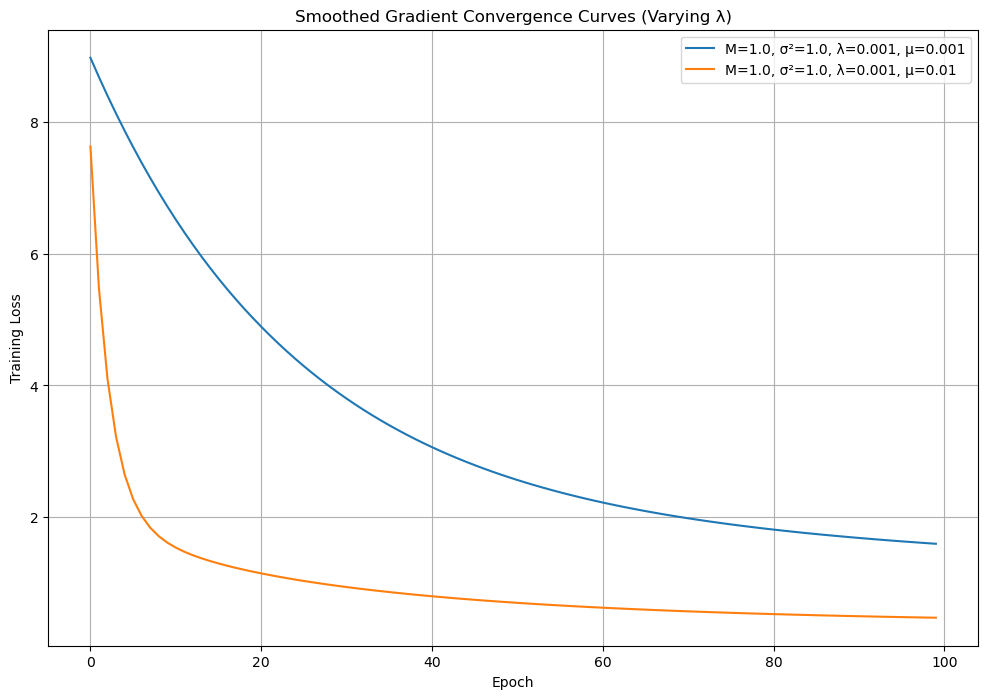

In [174]:
# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_california_housing_data(test_size=0.2, random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Set input_size as number of features, and output_size = 1.
    input_size = X.shape[1]
    hidden_size = 50  # fixed hidden layer size for the experiment
    output_size = 1
    return X_train, y_train, X_val, y_val, input_size, hidden_size, output_size

# Load and preprocess California Housing data.
X_train_ch, y_train_ch, X_val_ch, y_val_ch, input_size_ch, hidden_size_ch, output_size_ch = load_california_housing_data(test_size=0.2, random_state=42)

# Choose an appropriate number of epochs for this dataset.
epochs_ch = 100
seed = 42

print("Starting momentum-based experiments on California Housing Data...")
results_california = evaluate_experiments_smoothed(X_train_ch, y_train_ch, X_val_ch, y_val_ch,
                                                   input_size_ch, hidden_size_ch, output_size_ch,
                                                   epochs_ch, seed)

plot_experiment_results(results_california)

Starting momentum-based experiments on California Housing Data...
[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.001 => Train Loss: 0.3116, Val Loss: 0.2912, Sparsity: 0.00%, Total Time: 86.64s
[Smoothed] M=1.0, σ²=1.0, lambda = 0.001, μ=0.01 => Train Loss: 0.2454, Val Loss: 0.2467, Sparsity: 14.00%, Total Time: 85.76s


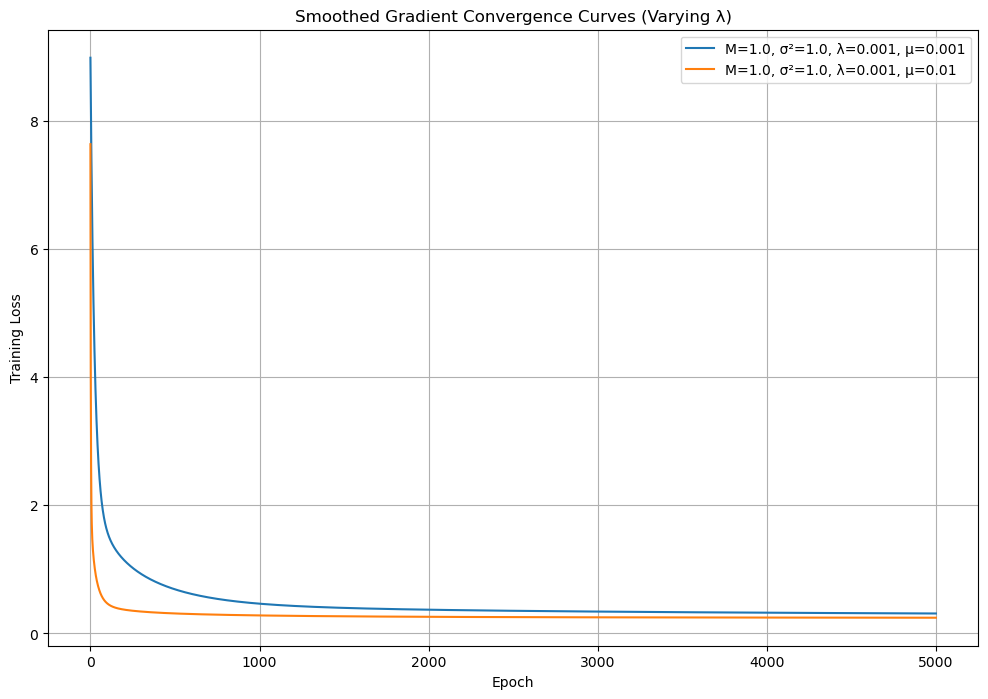

In [172]:
# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_california_housing_data(test_size=0.2, random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Set input_size as number of features, and output_size = 1.
    input_size = X.shape[1]
    hidden_size = 50  # fixed hidden layer size for the experiment
    output_size = 1
    return X_train, y_train, X_val, y_val, input_size, hidden_size, output_size

# Load and preprocess California Housing data.
X_train_ch, y_train_ch, X_val_ch, y_val_ch, input_size_ch, hidden_size_ch, output_size_ch = load_california_housing_data(test_size=0.2, random_state=42)

# Choose an appropriate number of epochs for this dataset.
epochs_ch = 5000
seed = 42

print("Starting momentum-based experiments on California Housing Data...")
results_california = evaluate_experiments_smoothed(X_train_ch, y_train_ch, X_val_ch, y_val_ch,
                                                   input_size_ch, hidden_size_ch, output_size_ch,
                                                   epochs_ch, seed)

plot_experiment_results(results_california)